<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/09_SkimLit_Milestone_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
NLP model to make reading medical abstracts easier

## Paper referenced:
* [https://arxiv.org/abs/1710.06071](https://arxiv.org/abs/1710.06071)
* [https://arxiv.org/abs/1612.05251](https://arxiv.org/abs/1612.05251)

In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8a7e891a-7b6f-0f33-ecb2-c4c67a0c1804)


In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results

--2022-07-30 09:22:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-07-30 09:22:41 (94.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# Getting & Pre-Processing Data
Source: [https://github.com/Franck-Dernoncourt/pubmed-rct](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [ ]:
!head pubmed-rct/PubMed_20k_RCT/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of 6 weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at 12 weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of 125 patients with primary knee OA were randomized 1:1 ; 63 received 7.5 mg/day of prednisolone and 62 received placebo for 6 weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( 0-100 mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and 6-min walk distance ( 6MWD ) .
METHODS	Serum levels of interleukin 1 ( IL-1 ) , IL-6 , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein

In [ ]:
!head pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt

###24293578
OBJECTIVE	To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .
METHODS	A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .
METHODS	Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .
METHODS	Pain was assessed using the visual analog pain scale ( @-@ mm ) .
METHODS	Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .
METHODS	Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP 

In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
def get_lines(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
train_lines = get_lines(data_dir+"/train.txt")
train_lines[:27]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [ ]:
for i in enumerate(train_lines[:10]):
  print(i)

(0, '###24293578\n')
(1, 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n')
(2, 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n')
(3, 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n')
(4, 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n')
(5, 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n')
(6, 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis fa

In [ ]:
def preprocess_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  
 
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

     
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target, text = abstract_line.split("\t")
        line_data["target"] = target
        line_data["text"] = text.lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    
    else:
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 423 ms, sys: 85 ms, total: 508 ms
Wall time: 512 ms


# Visualising Dataset

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

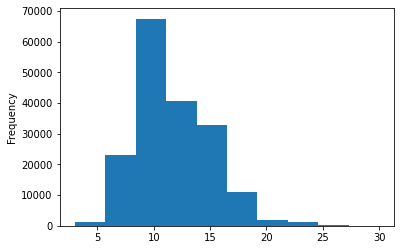

In [ ]:
train_df.total_lines.plot.hist();

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

# Encoding labels

In [ ]:
# one hot encoding
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [ ]:
# Encode Labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
classes = label_encoder.classes_
num_classes = len(classes)
classes

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

# Model 0: Baseline Model, TF-IDF Multinomial Naive Bayes Classifier

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(
    train_sentences,
    train_labels_encoded
)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences, val_labels_encoded)

0.7218323844829869

In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
model_0_results = calculate_results(val_labels_encoded, baseline_preds)
model_0_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

# Preparing text for deep learning

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lengths = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lengths = np.mean(sent_lengths)
avg_sent_lengths

26.338269273494777

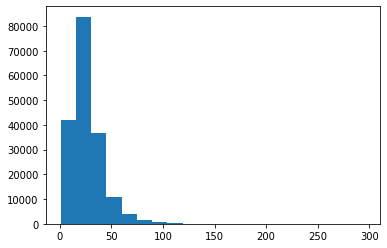

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lengths, bins=20);

In [ ]:
output_seq_len = int(np.percentile(sent_lengths, 95))
output_seq_len

55

In [ ]:
max(sent_lengths)

296

## Vectorizing on training sentences

In [ ]:
MAX_TOKENS = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=output_seq_len
)

In [ ]:
vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text:\n{len(target_sentence.split())}")
print(f"\nVectorized Text:\n{vectorizer([target_sentence])}")

Text:
posaconazole has shown trypanocidal activity in murine models .

Length of text:
9

Vectorized Text:
[[10602   139   512 27996   190     5 25635   476     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_vocab = vectorizer.get_vocabulary()
print(f"Word Count: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Word Count: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

## Creating token Embedding

In [ ]:
from tensorflow.keras.layers import Embedding 

In [ ]:
token_embedding = Embedding(
    input_dim=len(rct_20k_vocab),
    output_dim=128,
    mask_zero=True,
    name="token_embedding"
)

In [ ]:
print(f"Normal:\n{target_sentence}")
print(f"\nVectorized:\n{vectorizer([target_sentence])}")
print(f"\nVectorized shape: {vectorizer([target_sentence]).shape}")
print(f"\nEmbedding:\n{token_embedding(vectorizer([target_sentence]))}")
print(f"\nEmbedding shape: {token_embedding(vectorizer([target_sentence])).shape}")

Normal:
posaconazole has shown trypanocidal activity in murine models .

Vectorized:
[[10602   139   512 27996   190     5 25635   476     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Vectorized shape: (1, 55)

Embedding:
[[[ 0.02946582 -0.04913891 -0.00649925 ...  0.0468266  -0.04885305
   -0.00952483]
  [ 0.03857834 -0.01012812 -0.04777644 ...  0.02908054 -0.04486225
   -0.02993027]
  [-0.00573205  0.02158352 -0.0396883  ...  0.0232849  -0.00479454
    0.01238084]
  ...
  [-0.03964506 -0.01619102  0.01385467 ...  0.03284233 -0.00820017
   -0.00823105]
  [-0.03964506 -0.01619102  0.01385467 ...  0.03284233 -0.00820017
   -0.00823105]
  [-0.03964506 -0.01619102  0.01385467 ...  0.03284233 -0.00820017
   -0.00823105]]]

Embedding shape: (1, 55, 12

# Creating Datasets

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

# Model 1: Conv1D with token embeddings

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = vectorizer(inputs)
token_embeddings = token_embedding(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
history_model_1 = model_1.fit(
    train_dataset,
    steps_per_epoch=int(0.1*len(train_dataset)),
    epochs=3,
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 18s 9ms/step - loss: 0.9048 - accuracy: 0.6449 - val_loss: 0.6819 - val_accuracy: 0.7397
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6595 - accuracy: 0.7566 - val_loss: 0.6310 - val_accuracy: 0.7709
Epoch 3/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6202 - accuracy: 0.7724 - val_loss: 0.5990 - val_accuracy: 0.7852


In [ ]:
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.6018 - accuracy: 0.7848


[0.6018190383911133, 0.7848206162452698]

In [ ]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.2892540e-01, 1.8851241e-01, 8.2217097e-02, 2.7274257e-01,
         2.7602484e-02],
        [4.2483968e-01, 2.9714024e-01, 1.1765779e-02, 2.5843230e-01,
         7.8219660e-03],
        [1.5174760e-01, 1.0638697e-02, 2.3684551e-03, 8.3520746e-01,
         3.7808550e-05],
        ...,
        [6.0783423e-06, 8.5208687e-04, 9.5077557e-04, 3.4828670e-06,
         9.9818760e-01],
        [5.3059924e-02, 4.6248394e-01, 9.0523481e-02, 6.4308561e-02,
         3.2962406e-01],
        [1.5729843e-01, 7.0550048e-01, 3.3502400e-02, 3.8900193e-02,
         6.4798608e-02]], dtype=float32), (30212, 5))

In [ ]:
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(val_labels_encoded, model_1_preds)
model_1_results, model_0_results

({'accuracy': 78.48206010856613,
  'f1': 0.7824721533350028,
  'precision': 0.7821055741486189,
  'recall': 0.7848206010856613},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

# Model 2 Feature Extraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    trainable=False,
    name="universal_sentence_encoder"
)

In [ ]:
random_train_sentence = random.choice(train_sentences)
print(random_train_sentence)
USE_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(USE_embedded_sentence[0][:10])
print(len(USE_embedded_sentence[0]))

serious adverse events were reported by @ patients treated with tnf-k ( @ % ) and @ treated with placebo ( @ % ) , all unrelated to treatment .
tf.Tensor(
[-0.07563521  0.05798686  0.05889975 -0.06565973  0.06928847 -0.02967991
  0.01638944 -0.05024684  0.0025563   0.01201417], shape=(10,), dtype=float32)
512


In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embeddings = tf_hub_embedding_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embeddings)
outputs = layers.Dense(5, activation="softmax")(x)

model_2 = tf.keras.Model(inputs, outputs, name="model_2_USE_feature_extractor")

model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
history_model_2 = model_2.fit(
    train_dataset,
    epochs=3,
    steps_per_epoch=int(0.1*len(train_dataset)),
    validation_data=valid_dataset,
    validation_steps=int(0.1*len(valid_dataset))
)

Epoch 1/3
562/562 [==============================] - 13s 20ms/step - loss: 0.9180 - accuracy: 0.6496 - val_loss: 0.7986 - val_accuracy: 0.6882
Epoch 2/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7716 - accuracy: 0.7005 - val_loss: 0.7587 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 7s 13ms/step - loss: 0.7564 - accuracy: 0.7107 - val_loss: 0.7432 - val_accuracy: 0.7118


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 10s 11ms/step - loss: 0.7455 - accuracy: 0.7118


[0.7454891800880432, 0.7118032574653625]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[0.43679187, 0.36451548, 0.0022128 , 0.18860082, 0.00787906],
       [0.32420185, 0.5136166 , 0.00236307, 0.15728359, 0.00253482],
       [0.2316716 , 0.13270494, 0.01892388, 0.57866454, 0.03803507],
       ...,
       [0.00214541, 0.00723591, 0.05470861, 0.00097372, 0.93493634],
       [0.00359518, 0.04394282, 0.21500072, 0.00142572, 0.7360355 ],
       [0.19945209, 0.27909043, 0.45168886, 0.00824639, 0.06152225]],
      dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(val_labels_encoded, model_2_preds)
model_2_results

{'accuracy': 71.18032569839798,
 'f1': 0.7090430225572565,
 'precision': 0.7119343661412568,
 'recall': 0.7118032569839798}

In [ ]:
model_0_results, model_1_results, model_2_results

({'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869},
 {'accuracy': 78.48206010856613,
  'f1': 0.7824721533350028,
  'precision': 0.7821055741486189,
  'recall': 0.7848206010856613},
 {'accuracy': 71.18032569839798,
  'f1': 0.7090430225572565,
  'precision': 0.7119343661412568,
  'recall': 0.7118032569839798})

# Model 3: Conv1D with character embeddings

In [ ]:
train_chars = [" ".join(list(sentence)) for sentence in train_sentences]
val_chars = [" ".join(list(sentence)) for sentence in val_sentences]
test_chars = [" ".join(list(sentence)) for sentence in test_sentences]

train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
output_seq_char_len = int(np.percentile([len(sentence) for sentence in train_sentences], 95))
output_seq_char_len

290

In [ ]:
import string

NUM_CHAR_TOKENS = len(string.ascii_lowercase + string.digits + string.punctuation) + 2
char_vectorizer = TextVectorization(
    max_tokens=NUM_CHAR_TOKENS,
    output_sequence_length=output_seq_char_len,
    name="char_vectorizer"
)

In [ ]:
char_vectorizer.adapt(train_chars)
char_vocab = char_vectorizer.get_vocabulary()

print(f"top 5: {char_vocab[:5]}")
print(f"bot 5: {char_vocab[-5:]}")

top 5: ['', '[UNK]', 'e', 't', 'i']
bot 5: ['k', 'x', 'z', 'q', 'j']


In [ ]:
random_chars = random.choice(train_chars)
vectorized_chars = char_vectorizer([random_chars])

print(random_chars)
print(vectorized_chars)
print(len(vectorized_chars[0]))

t h e   c t   d i a g n o s t i c   s t a n d a r d   ,   d e r i v e d   f r o m   g r o u p   a   ,   w a s   u s e d   t o   a n a l y z e   t h e   p a t h o l o g i c   t y p e   o f   g r o u p   b .   a n d   t   n o   s i g n i f i c a n t   s t a t i s t i c   s i g n i f i c a n c e   e x i s t e d   b e t w e e n   c t   p r e o p e r a t i v e   d i a g n o s i s   a n d   o p e r a t i v e   p a t h o l o g i c   d i a g n o s i s   (   p   >   @   )   .
tf.Tensor(
[[ 3 13  2 11  3 10  4  5 18  6  7  9  3  4 11  9  3  5  6 10  5  8 10 10
   2  8  4 21  2 10 17  8  7 15 18  8  7 16 14  5 20  5  9 16  9  2 10  3
   7  5  6  5 12 19 25  2  3 13  2 14  5  3 13  7 12  7 18  4 11  3 19 14
   2  7 17 18  8  7 16 14 22  5  6 10  3  6  7  9  4 18  6  4 17  4 11  5
   6  3  9  3  5  3  4  9  3  4 11  9  4 18  6  4 17  4 11  5  6 11  2  2
  24  4  9  3  2 10 22  2  3 20  2  2  6 11  3 14  8  2  7 14  2  8  5  3
   4 21  2 10  4  5 18  6  7  9  4  9  5  6 10  7 14  2  8  5  3  4 21  2

In [ ]:
char_embedding = Embedding(
    len(char_vocab),
    25, # from the paper
    mask_zero=True,
    name="char_embed"
)

In [ ]:
print(char_embedding(vectorized_chars))

tf.Tensor(
[[[-0.01408129  0.01748803 -0.0022063  ... -0.04612466  0.00589671
    0.01306761]
  [-0.01401559  0.04396204  0.02858948 ... -0.03399485 -0.04696019
   -0.00339718]
  [-0.02011247 -0.03706848  0.04018735 ... -0.02320889  0.01767241
    0.02619069]
  ...
  [ 0.04950928  0.00939519 -0.04477494 ... -0.03673831  0.038413
   -0.01741251]
  [ 0.04950928  0.00939519 -0.04477494 ... -0.03673831  0.038413
   -0.01741251]
  [ 0.04950928  0.00939519 -0.04477494 ... -0.03673831  0.038413
   -0.01741251]]], shape=(1, 290, 25), dtype=float32)


In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
vectorizer_layer = char_vectorizer(inputs)
embedding_layer = char_embedding(vectorizer_layer)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedding_layer)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(
    inputs=inputs,
    outputs=outputs,
    name="model_3_conv1d")

model_3.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_3.summary()

Model: "model_3_conv1d"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 5)              

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

train_char_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_model_3 = model_3.fit(
    train_char_dataset,
    steps_per_epoch=int(0.1*len(train_char_dataset)),
    epochs=3,
    validation_data=val_char_dataset,
    validation_steps=int(0.1*len(val_char_dataset))
)

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2795 - accuracy: 0.4805 - val_loss: 1.0743 - val_accuracy: 0.5731
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.0266 - accuracy: 0.5863 - val_loss: 0.9545 - val_accuracy: 0.6223
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9432 - accuracy: 0.6274 - val_loss: 0.8772 - val_accuracy: 0.6576


In [ ]:
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.9053 - accuracy: 0.6487


[0.9053376913070679, 0.6487157344818115]

In [ ]:
model_3_preds = tf.argmax(model_3.predict(val_char_dataset), axis=1)
model_3_results = calculate_results(val_labels_encoded, model_3_preds)
model_3_results, model_2_results, model_1_results, model_0_results

({'accuracy': 64.8715742089236,
  'f1': 0.6381924078073933,
  'precision': 0.6471604647379977,
  'recall': 0.6487157420892361},
 {'accuracy': 71.18032569839798,
  'f1': 0.7090430225572565,
  'precision': 0.7119343661412568,
  'recall': 0.7118032569839798},
 {'accuracy': 78.48206010856613,
  'f1': 0.7824721533350028,
  'precision': 0.7821055741486189,
  'recall': 0.7848206010856613},
 {'accuracy': 72.1832384482987,
  'f1': 0.6989250353450294,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869})

# Model 4: Hybrid Model with token and character embedding

In [ ]:
# token model
token_inputs = layers.Input(shape=[], dtype=tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

# char model
char_inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

# concatenate models
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# create output layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# build model
model_4 = tf.keras.Model(
    inputs=[token_model.input, char_model.input],
    outputs=output_layer,
    name="model_4_hybrid_model"
)

model_4.summary()

Model: "model_4_hybrid_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['input_5[0][0]']                
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_4[0][0

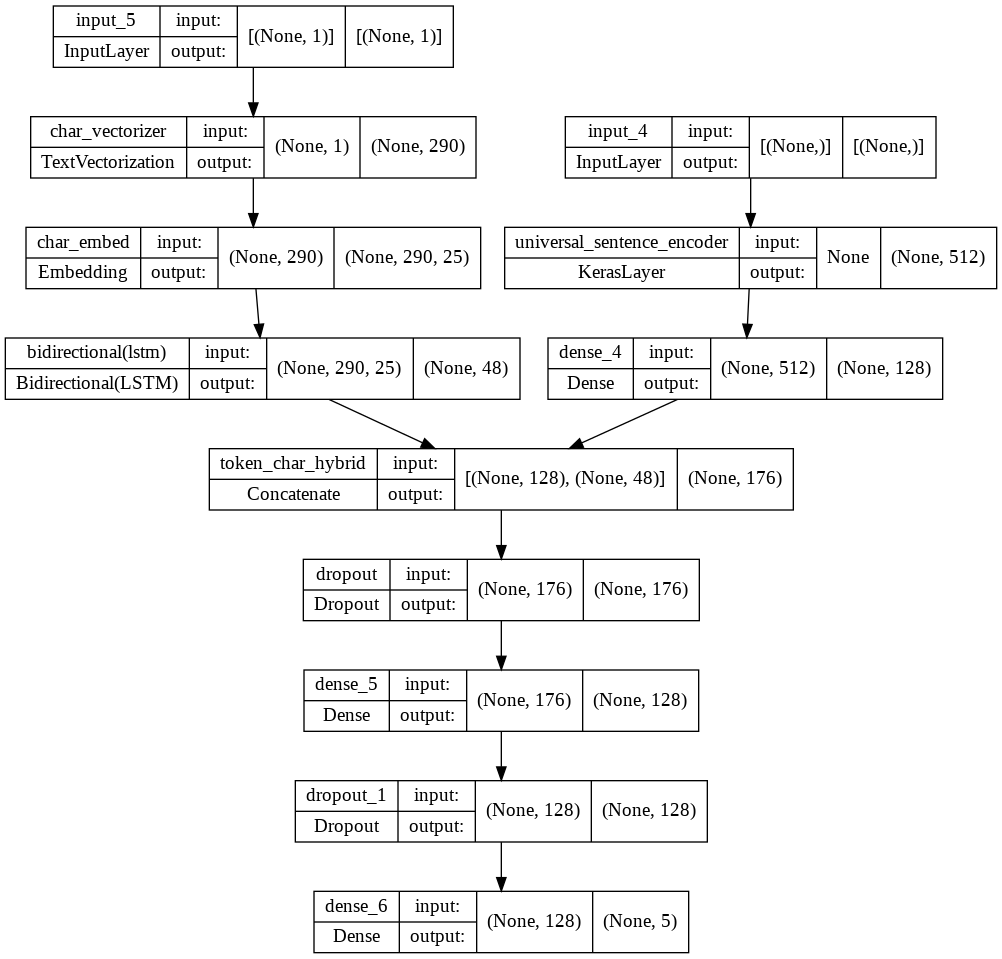

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model_4, show_shapes=True)

In [ ]:
model_4.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Creating Multimodal datasets

In [ ]:
from tensorflow.data import Dataset

In [ ]:
train_char_token_dataset = Dataset.zip((
    Dataset.from_tensor_slices((train_sentences, train_chars)), # data
    Dataset.from_tensor_slices(train_labels_one_hot)            # labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_dataset = Dataset.zip((
    Dataset.from_tensor_slices((val_sentences, val_chars)), # data
    Dataset.from_tensor_slices(val_labels_one_hot)          # labels
)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Fitting model to dataset

In [ ]:
history_model_4 = model_4.fit(
    train_char_token_dataset,
    steps_per_epoch=int(0.1*len(train_char_token_dataset)),
    epochs=3,
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1*len(val_char_token_dataset)),
)

Epoch 1/3
562/562 [==============================] - 43s 60ms/step - loss: 0.9712 - accuracy: 0.6115 - val_loss: 0.7798 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 39s 69ms/step - loss: 0.8012 - accuracy: 0.6892 - val_loss: 0.7166 - val_accuracy: 0.7354
Epoch 3/3
562/562 [==============================] - 27s 48ms/step - loss: 0.7732 - accuracy: 0.7048 - val_loss: 0.6947 - val_accuracy: 0.7447


In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.6982 - accuracy: 0.7346


[0.6982349753379822, 0.7345756888389587]

In [ ]:
model_4_results = calculate_results(
    val_labels_encoded,
    tf.argmax(model_4.predict(val_char_token_dataset), axis=1)
)

model_4_results

{'accuracy': 73.45756652985568,
 'f1': 0.7326112582652609,
 'precision': 0.7373371787671018,
 'recall': 0.7345756652985569}

# Model 5: transfer Learning with pretrained token embeddings + character embeddings

line number is already added in the beginning

## Create Positional Embeddings

In [ ]:
train_df["line_number"].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

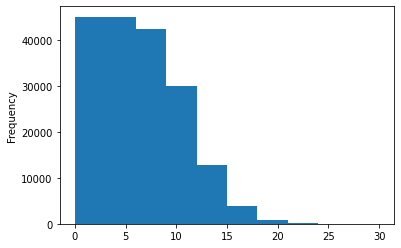

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:16], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(16, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [ ]:
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

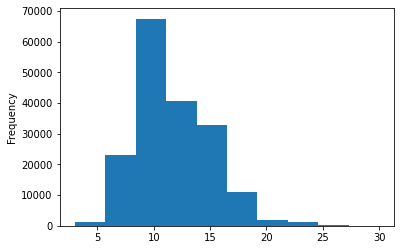

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
np.percentile(train_df.total_lines, 98)

20.0

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

## Creating the Model 5

In [ ]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs)

char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_bi_lstm)

line_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_inputs")
line_dense = layers.Dense(32, activation="relu")(line_inputs)
line_model = tf.keras.Model(line_inputs, line_dense)

total_lines_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="total_lines_inputs")
total_lines_dense = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(total_lines_inputs, total_lines_dense)

combine_embeddings = layers.Concatenate(name="char_token_hybrid_embeddings")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combine_embeddings)
z = layers.Dropout(0.5)(z)

tri_embeddings = layers.Concatenate(name="char_token_positional_embeddings")([line_model.output, total_lines_model.output, z])
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tri_embeddings)

model_5 = tf.keras.Model(inputs=[
  line_model.input,
  total_lines_model.input,
  token_model.input,
  char_model.input
], 
outputs=output_layer,
name="tribrid_embedding_model")

In [ ]:
model_5.summary()

Model: "tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inp

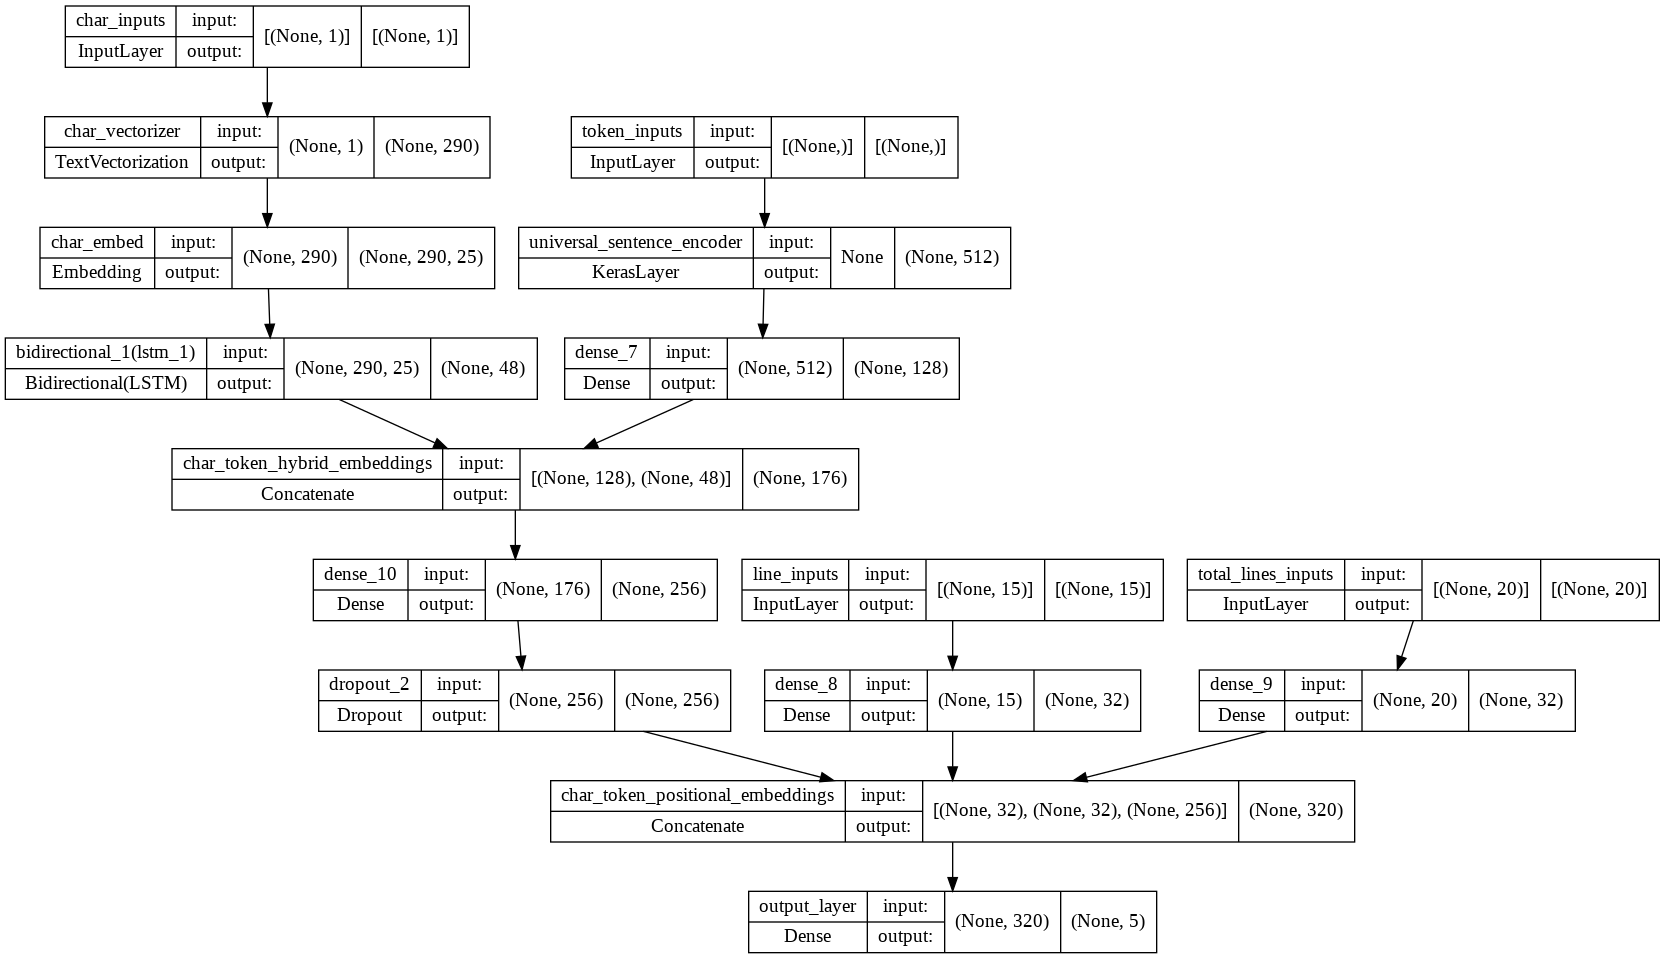

In [ ]:
plot_model(model_5, show_shapes=True)

In [ ]:
model_5.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

## Create the dataset

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    train_line_numbers_one_hot,
    train_total_lines_one_hot,
    train_sentences,
    train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    val_line_numbers_one_hot,
    val_total_lines_one_hot,
    val_sentences,
    val_chars))

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_dataset

<PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Fitting the model

In [ ]:
history_model_5 = model_5.fit(
    train_pos_char_token_dataset,
    steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
    epochs=3
)

Epoch 1/3
94/94 [==============================] - 7s 71ms/step - loss: 0.8415 - accuracy: 0.9096
Epoch 2/3
94/94 [==============================] - 6s 66ms/step - loss: 0.9296 - accuracy: 0.8295
Epoch 3/3
94/94 [==============================] - 4s 40ms/step - loss: 0.9364 - accuracy: 0.8218


In [ ]:
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 36s 38ms/step


array([[0.63918287, 0.07308511, 0.01117302, 0.25459436, 0.02196453],
       [0.53628784, 0.10763866, 0.0416837 , 0.29805008, 0.01633976],
       [0.28989425, 0.09465632, 0.07379319, 0.49581495, 0.04584131],
       ...,
       [0.03470083, 0.09361582, 0.04358153, 0.03603072, 0.7920711 ],
       [0.03457008, 0.46254107, 0.09107535, 0.03610321, 0.37571028],
       [0.08469096, 0.76235247, 0.09379716, 0.02818942, 0.03096998]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [ ]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)
model_5_results

{'accuracy': 85.98239110287304,
 'f1': 0.8585657187025035,
 'precision': 0.8586960769911322,
 'recall': 0.8598239110287303}

# Viewing Results

In [ ]:
all_model_results = pd.DataFrame({
    "model_0_baseline": model_0_results,
    "model_1_conv1d": model_1_results,
    "model_2_extraction": model_2_results,
    "model_3_char_embed": model_3_results,
    "model_4_hybrid": model_4_results,
    "model_4_tri-brid": model_5_results,
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1_conv1d,78.482060,0.782106,0.784821,0.782472
model_2_extraction,71.180326,0.711934,0.711803,0.709043
model_3_char_embed,64.871574,0.647160,0.648716,0.638192
model_4_hybrid,73.457567,0.737337,0.734576,0.732611
model_4_tri-brid,85.982391,0.858696,0.859824,0.858566


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"] / 100
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,0.007218,0.718647,0.721832,0.698925
model_1_conv1d,0.007848,0.782106,0.784821,0.782472
model_2_extraction,0.007118,0.711934,0.711803,0.709043
model_3_char_embed,0.006487,0.647160,0.648716,0.638192
model_4_hybrid,0.007346,0.737337,0.734576,0.732611
model_4_tri-brid,0.008598,0.858696,0.859824,0.858566


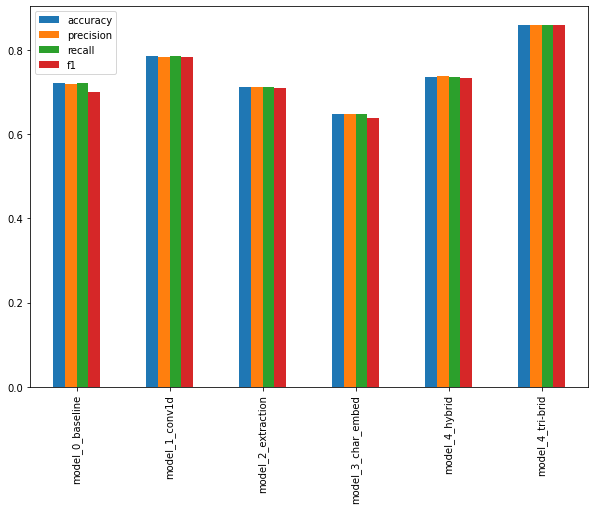

In [ ]:
all_model_results.plot(kind="bar", figsize=(10, 7))

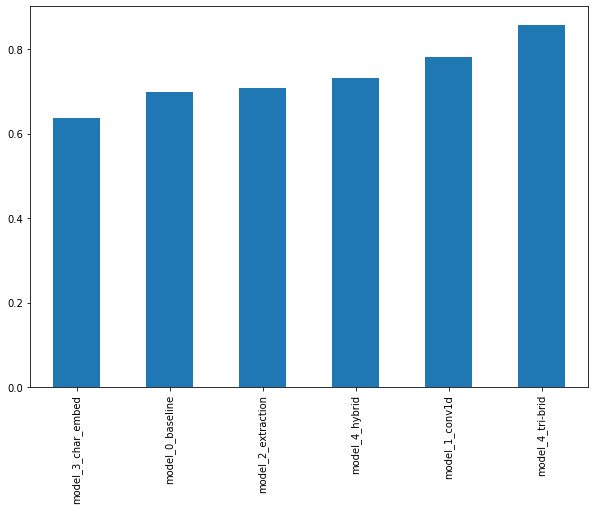

In [ ]:
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10, 7))

# Save and load best performing model (Model 5)

In [ ]:
model_5.save("skimlit_model_5")

INFO:tensorflow:Assets written to: skimlit_model_5/assets


INFO:tensorflow:Assets written to: skimlit_model_5/assets


In [ ]:
loaded_model = tf.keras.models.load_model("skimlit_model_5")

In [ ]:
loaded_pred_probs = loaded_model.predict(val_pos_char_token_dataset)
loaded_preds = tf.argmax(loaded_pred_probs, axis=1)
loaded_results = calculate_results(val_labels_encoded, loaded_preds)

loaded_results

{'accuracy': 85.98239110287304,
 'f1': 0.8585657187025035,
 'precision': 0.8586960769911322,
 'recall': 0.8598239110287303}